# Demo

This demo shows how to run our cross-decomposition analyses using a high-level API. If you're interested in the low-level details of how this works, feel free to check out the source code!

In [1]:
import tempfile
import warnings
from pathlib import Path

import seaborn as sns
import xarray as xr
from bonner.plotting import DEFAULT_MATPLOTLIBRC
from matplotlib import pyplot as plt
from osfclient.api import OSF

from lib.datasets import (
    compute_shared_stimuli,
    filter_by_stimulus,
    nsd,
    split_by_repetition,
)
from lib.spectra import (
    compute_cross_individual_spectra,
    compute_within_individual_spectra,
    plot_spectra,
)

sns.set_theme(context="paper", style="ticks", rc=DEFAULT_MATPLOTLIBRC)
warnings.filterwarnings("ignore")


## Prepare the datasets (~300 MB download)

Here, we analyze a small subset of the Natural Scenes Dataset containing fMRI responses from the primary visual cortex (V1) to 1,000 natural images seen twice by each of two individuals.

We inspect the data for one individual, which shows the matrix of fMRI activations to 1,000 natural images (along the `presentation` dimension) from 1,350 voxels (along the `neuroid` dimension) along with the associated metadata.

In [2]:
def load_toy_datasets() -> dict[int, dict[int, xr.DataArray]]:
    datasets = {}
    with tempfile.TemporaryDirectory() as tmpdir:
        project_id = "ft8b5"

        storage = OSF().project(project_id=project_id).storage("osfstorage")

        for file_ in storage.files:
            filepath = Path(tmpdir) / file_.path.lstrip("/")
            filepath.parent.mkdir(exist_ok=True, parents=True)
            with open(filepath, mode="wb") as f:
                file_.write_to(f)

            dataset = xr.load_dataarray(filepath).assign_attrs({"roi": "V1"})
            identifier = ".".join([
                f"{key}={value}" for key, value in dataset.attrs.items()
            ])
            datasets[dataset.attrs["subject"]] = (
                dataset.rename(f"{nsd.IDENTIFIER}.{identifier}")
                .set_xindex(["stimulus", "repetition"])
                .set_xindex(["x", "y", "z"])
            )

    # filter both datasets to extract only responses to the 1,000 shared images
    # split each of them by repetition, i.e. the responses on trials 1 and 2.
    shared_stimuli = compute_shared_stimuli(datasets.values(), n_repetitions=2)

    return {
        subject: split_by_repetition(
            filter_by_stimulus(dataset, stimuli=shared_stimuli),
            n_repetitions=2,
        )
        for subject, dataset in datasets.items()
    }


datasets = load_toy_datasets()
datasets[0][0]

100%|██████████| 162M/162M [00:01<00:00, 86.1Mbytes/s] 
100%|██████████| 133M/133M [00:01<00:00, 89.0Mbytes/s] 


<xarray.DataArray 'allen2021.natural_scenes.resolution=1pt8mm.preprocessing=fithrf.z_score=True.subject=0.roi=V1.stimuli=08cccf5b.repetition=0' (
                                                                                                                                                 presentation: 1000,
                                                                                                                                                 neuroid: 1350)> Size: 5MB
array([[ 1.3359803 ,  2.577477  ,  1.6856064 , ..., -1.3889635 ,
         1.3947762 , -1.2473638 ],
       [-0.8612751 , -0.19215818, -0.36553892, ..., -0.46330434,
         0.40328488,  1.0969934 ],
       [-0.61052376,  0.08783595,  0.2216204 , ..., -0.7296639 ,
        -0.6507732 ,  0.02443066],
       ...,
       [-1.0000101 ,  0.9789233 , -0.8314852 , ..., -0.54000616,
         0.8446126 , -0.34475094],
       [ 0.6976583 , -1.2656873 ,  1.4583833 , ..., -0.06594504,
        -1.0257719 , -1.7760327 ],
       [ 1.1388849 , -0.67647266, -0.10966816, ...,  0.36101988,
        -0.17250754,  1.5630496 ]], dtype=float32)
Coordinates:
    session       (presentation) uint8 1kB 3 24 8 5 10 1 15 ... 7 9 3 24 9 3 14
    trial         (presentation) uint16 2kB 365 457 298 538 ... 618 142 675 626
    run           (presentation) uint8 1kB 5 7 4 8 9 5 5 4 ... 6 3 10 9 2 10 10
  * presentation  (presentation) object 8kB MultiIndex
  * stimulus      (presentation) uint32 4kB 2950 2990 3049 ... 72605 72719 72948
  * repetition    (presentation) uint8 1kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
  * neuroid       (neuroid) object 11kB MultiIndex
  * x             (neuroid) uint8 1kB 31 31 31 31 31 31 32 ... 58 58 58 58 59 59
  * y             (neuroid) uint8 1kB 4 5 6 6 8 8 4 4 ... 9 9 10 10 10 10 10 10
  * z             (neuroid) uint8 1kB 43 42 41 42 37 38 41 ... 43 44 45 46 44 45
Attributes:
    resolution:     1pt8mm
    preprocessing:  fithrf
    z_score:        True
    subject:        0
    roi:            V1
    stimuli:        08cccf5b
    repetition:     0

## Cross-decomposition analysis

Given two datasets $X \in \mathbb{R}^{n \times d_X}$ and $Y \in \mathbb{R}^{n \times d_Y}$ containing fMRI activations to $n$ stimuli from $d_X$, $d_Y$ voxels, we identify the latent dimensions shared between $X$ and $Y$ on a training subset of stimuli,

$$
\begin{align*}
    \text{cov} \left(X_\text{train}, Y_\text{train}\right)
    &= \dfrac{1}{n_\text{train}} X_\text{train}^\top Y_\text{train}\\
    &= U \Sigma V^\top
\end{align*}
$$

and evaluating the stimulus-related variance by projecting held-out test data on the learnt latent dimensions:

$$
\begin{align*}
    \Sigma_\text{test}
    &= \text{cov} \left(X_\text{test} U, Y_\text{test} V\right)\\
    &= \dfrac{1}{n_\text{test}} \left(X_\text{test} U \right)^\top \left(Y_\text{test} V\right) \;.\\
\end{align*}
$$

We extract the diagonal of this matrix, bin it logarithmically across ranks, and average the spectra across 8 cross-validation folds.

### Computing within-individual covariance spectra

When we compute within-individual covariance spectra, we measure stimulus-related variance that generalizes across multiple presentations of the same stimuli within an individual, i.e. $X$ and $Y$ are data matrices from the same individual on different trials.

individual:   0%|          | 0/2 [00:00<?, ?it/s]

fold:   0%|          | 0/8 [00:00<?, ?it/s]

fold:   0%|          | 0/8 [00:00<?, ?it/s]

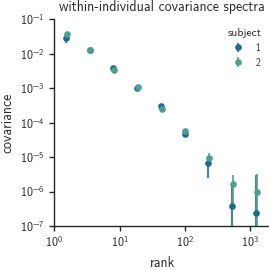

In [3]:
spectra = compute_within_individual_spectra(
    datasets,
    n_folds=8,
)

fig, ax = plt.subplots()
plot_spectra(
    spectra,
    ax=ax,
    hue="individual",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(left=1, right=2e3)
ax.set_ylim(top=1e-1, bottom=1e-7)
ax.legend(title="subject")
ax.set_title("within-individual covariance spectra")
ax.set_xlabel("rank")
ax.set_ylabel("covariance")
fig.show()

### Computing cross-individual covariance spectra

When we compute cross-individual covariance spectra, we measure stimulus-related variance that generalizes across different individuals, i.e. $X$ and $Y$ are data matrices from different individuals.

individual:   0%|          | 0/2 [00:00<?, ?it/s]

fold:   0%|          | 0/8 [00:00<?, ?it/s]

fold:   0%|          | 0/8 [00:00<?, ?it/s]

fold:   0%|          | 0/8 [00:00<?, ?it/s]

fold:   0%|          | 0/8 [00:00<?, ?it/s]

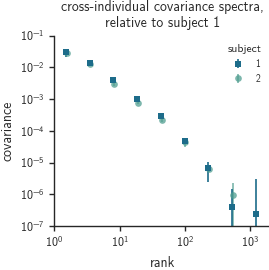

In [4]:
reference_subject = 0

spectra = compute_cross_individual_spectra(
    datasets,
    reference_individual=reference_subject,
    n_folds=8,
)

fig, ax = plt.subplots()
plot_spectra(
    spectra,
    ax=ax,
    hue="individual",
    hue_reference=f"{1 + reference_subject}",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(left=1, right=2e3)
ax.set_ylim(top=1e-1, bottom=1e-7)
ax.legend(title="subject")
ax.set_title(
    f"cross-individual covariance spectra,\nrelative to subject {1 + reference_subject}",
)
ax.set_xlabel("rank")
ax.set_ylabel("covariance")
fig.show()

## Scale-free power law structure

Even in this simple demonstration, we see that the covariance spectra have a scale-free power-law structure, both within an individual and shared between individuals. In our paper, we go into much more detail about what this means, so check it out!